# Time Series Power Consumption



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline


from keras.layers import *


## DATA

The data is the measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.

 Different electrical quantities and some sub-metering values are available.

In [2]:
df=pd.read_csv('household_power_consumption.txt', delimiter=';')
df.head(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
df.shape

(2075259, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [6]:
(df['Global_active_power'] == 0).sum()

0

In [7]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['date_time']

0         2006-12-16 17:24:00
1         2006-12-16 17:25:00
2         2006-12-16 17:26:00
3         2006-12-16 17:27:00
4         2006-12-16 17:28:00
                  ...        
2075254   2010-11-26 20:58:00
2075255   2010-11-26 20:59:00
2075256   2010-11-26 21:00:00
2075257   2010-11-26 21:01:00
2075258   2010-11-26 21:02:00
Name: date_time, Length: 2075259, dtype: datetime64[ns]

In [8]:
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time,year,quarter,month,day
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00,2006,4,12,16
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00,2006,4,12,16
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00,2006,4,12,16
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00,2006,4,12,16
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00,2006,4,12,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00,2010,4,11,26
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0,2010-11-26 20:59:00,2010,4,11,26
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00,2010,4,11,26
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0,2010-11-26 21:01:00,2010,4,11,26


In [9]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time,year,quarter,month,day
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00,2006,4,12,16
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00,2006,4,12,16
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00,2006,4,12,16
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00,2006,4,12,16
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00,2006,4,12,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00,2010,4,11,26
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0,2010-11-26 20:59:00,2010,4,11,26
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00,2010,4,11,26
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0,2010-11-26 21:01:00,2010,4,11,26


In [10]:
df = df.dropna(subset=['Global_active_power'])
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time,year,quarter,month,day
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00,2006,4,12,16
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00,2006,4,12,16
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00,2006,4,12,16
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00,2006,4,12,16
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00,2006,4,12,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00,2010,4,11,26
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0,2010-11-26 20:59:00,2010,4,11,26
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00,2010,4,11,26
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0,2010-11-26 21:01:00,2010,4,11,26


In [11]:
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df

,date_time,Global_active_power,year,quarter,month,day
0,2006-12-16 17:24:00,4.216,2006,4,12,16
1,2006-12-16 17:25:00,5.360,2006,4,12,16
2,2006-12-16 17:26:00,5.374,2006,4,12,16
3,2006-12-16 17:27:00,5.388,2006,4,12,16
4,2006-12-16 17:28:00,3.666,2006,4,12,16
...,...,...,...,...,...,...
2049275,2010-12-11 23:55:00,0.690,2010,4,12,11
2049276,2010-12-11 23:56:00,0.688,2010,4,12,11
2049277,2010-12-11 23:57:00,0.688,2010,4,12,11
2049278,2010-12-11 23:58:00,0.688,2010,4,12,11


In [12]:
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
df

,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.216,2006,4,12,16,0
1,2006-12-16 17:25:00,5.360,2006,4,12,16,0
2,2006-12-16 17:26:00,5.374,2006,4,12,16,0
3,2006-12-16 17:27:00,5.388,2006,4,12,16,0
4,2006-12-16 17:28:00,3.666,2006,4,12,16,0
...,...,...,...,...,...,...,...
2049275,2010-12-11 23:55:00,0.690,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.688,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.688,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.688,2010,4,12,11,0


In [13]:
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())

(2049280, 7)
2006-12-16 17:24:00
2010-12-11 23:59:00


In [14]:
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


In [15]:
df.Global_active_power.describe()

count    2.049280e+06
mean     1.091615e+00
std      1.057294e+00
min      7.600000e-02
25%      3.080000e-01
50%      6.020000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

### Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

In [16]:
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=', stat,"\n", 'p', p)
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics= 724881.7954617608 
 p 0.0
Data does not look Gaussian (reject H0)


### kurtosis and skewness

Is the data distribution departs from the normal distribution.

Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320832


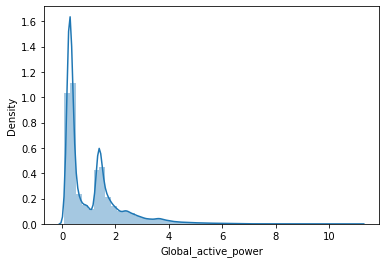

In [17]:
sns.distplot(df.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0.  If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero. 

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed.

### First Time series plot

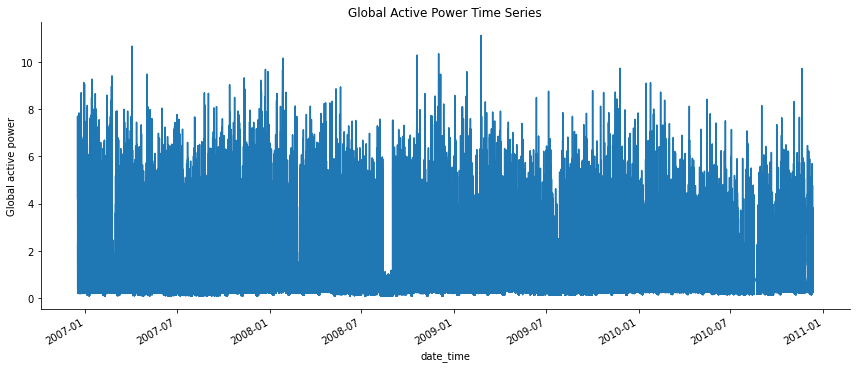

In [18]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

Apparently, this plot is not a good idea. Don't do this.

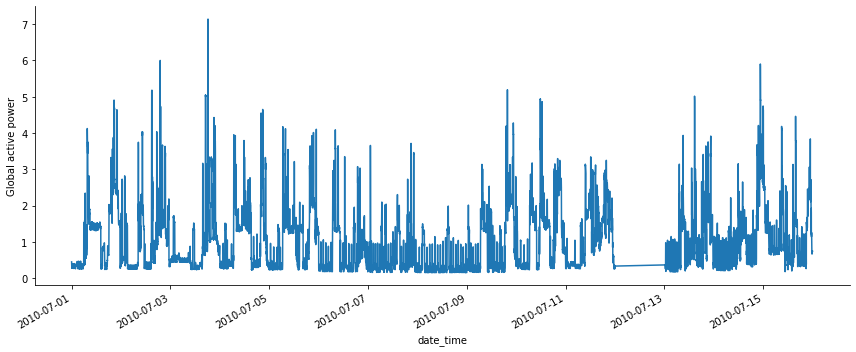

In [19]:
df2=df1[(df1.index>='2010-07-01') & (df1.index<'2010-7-16')]
df2.plot(figsize=(12,5));
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

### Box plot of yearly vs. quarterly Global active power

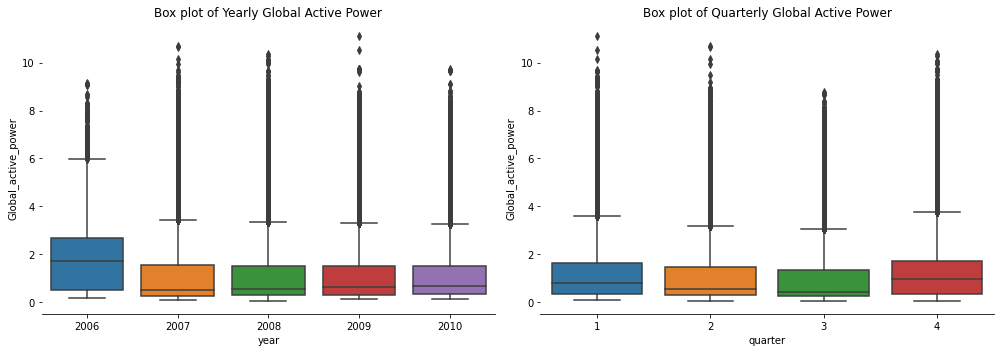

In [20]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

Median(Global_active_power) in 2006 is much higher than the other years'. This is a little bit misleading.

 Dataset has only December data for 2006. While apparently December is the peak month for household electric power consumption. 

This is consistent with the quarterly median global active power, it is higher in the 1st and 4th quarters (winter), and it is the lowest in the 3rd quarter (summer).

### Global Active Power Distribution

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


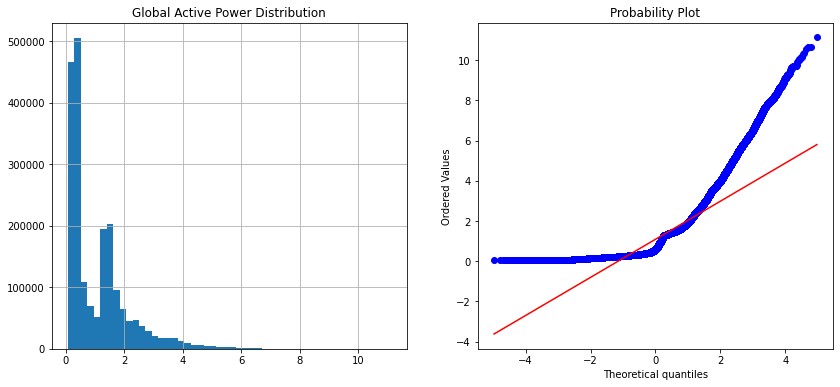

In [21]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt);
df1.describe().T

### Average Global Active Power resampled over day, week, month, quarter and year.

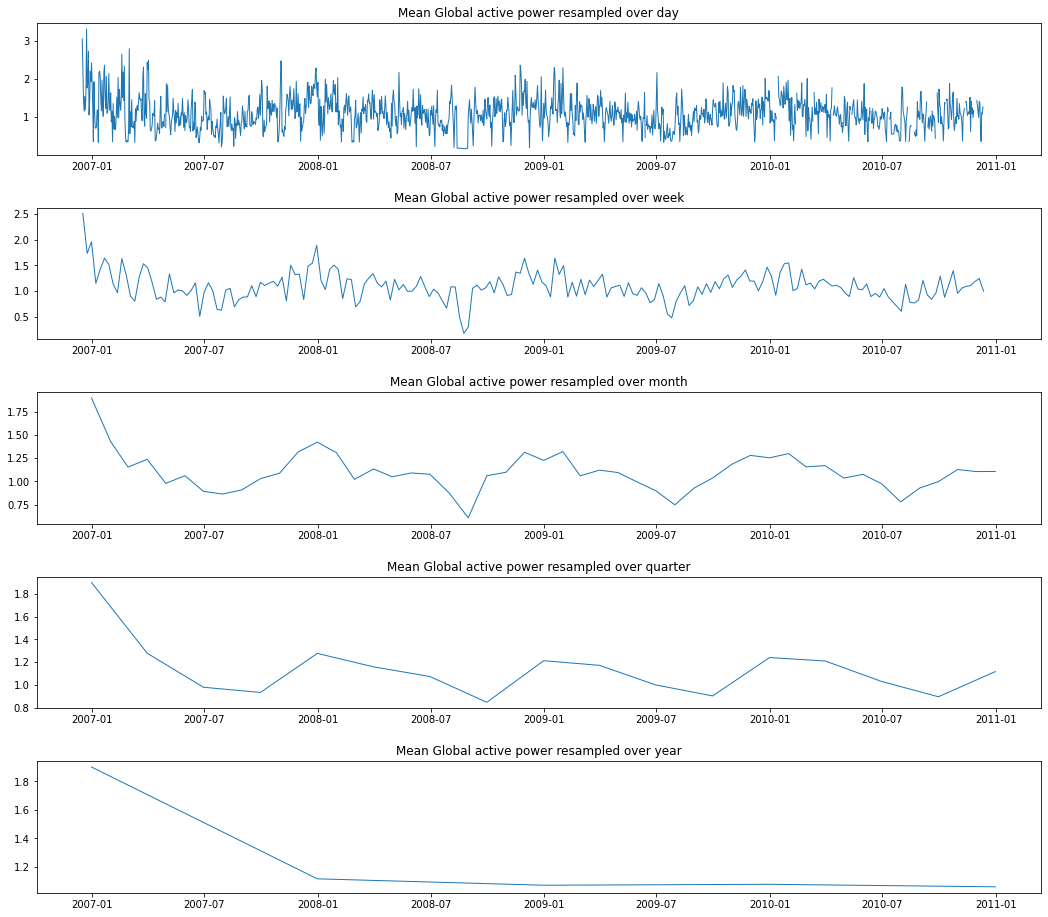

In [22]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

Time series data does not have a general upward or downward trend. The highest average power consumption was prior to 2007.


### Plot mean global active power grouped by year, quarter, month and day.

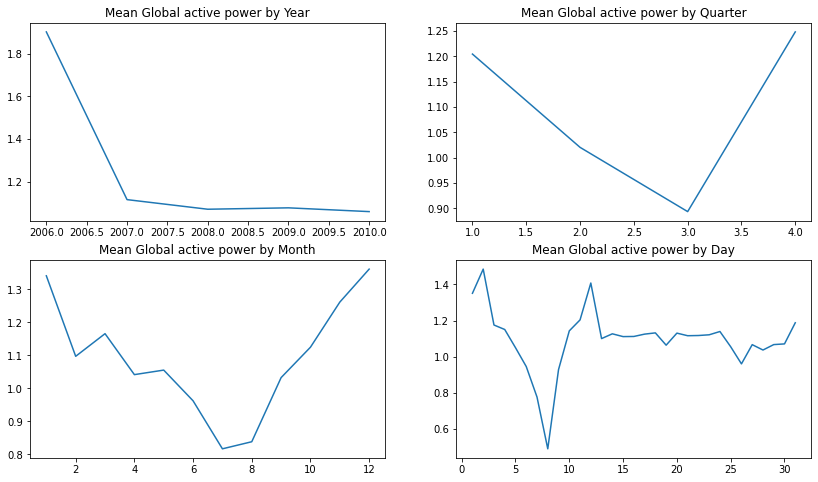

In [23]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

### Global Active Power by Years

For 2006, Only December data is available

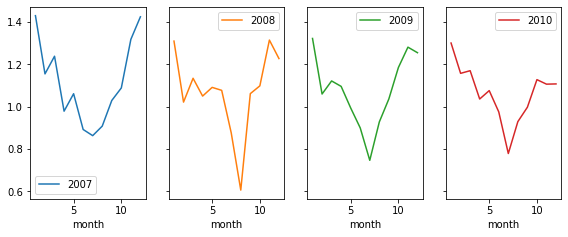

In [24]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

### Global active power consumption in Weekdays vs. Weekends

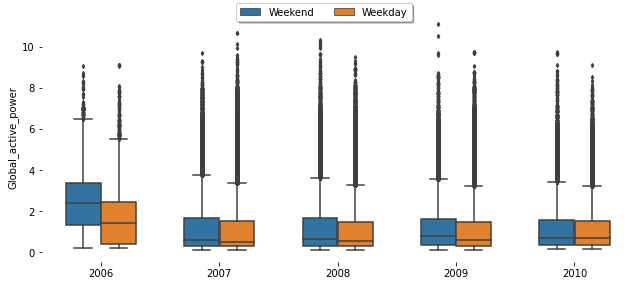

In [25]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)

a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

The median global active power in weekdays seems to be lower than the weekends prior to 2010.

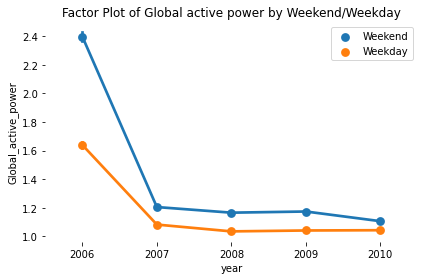

In [26]:
plt1=sns.factorplot('year','Global_active_power',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

Both weekdays and weekends have the similar trends over year.

There is no need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

### Dickey-Fuller Test to Ceck Stationarity

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [27]:
df2 = df1.resample('D').mean()

In [28]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

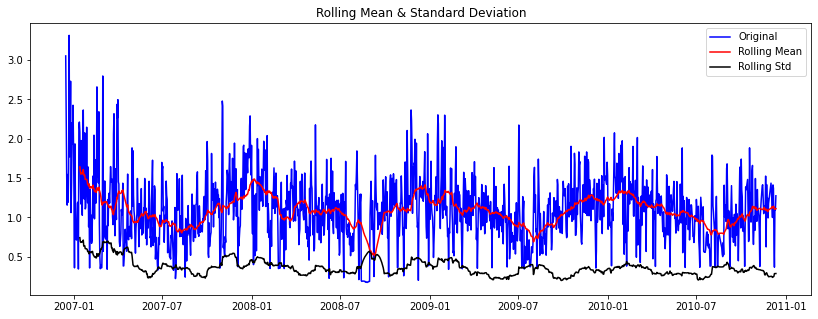

<Results of Dickey-Fuller Test>
Test Statistic                -8.327686e+00
p-value                        3.435135e-13
#Lags Used                     9.000000e+00
Number of Observations Used    1.423000e+03
Critical Value (1%)           -3.434954e+00
Critical Value (5%)           -2.863573e+00
Critical Value (10%)          -2.567852e+00
dtype: float64


In [29]:
test_stationarity(df2.Global_active_power.dropna())

From the above results

Rejecting the null hypothesis H0, the data does not have a unit root and is stationary.

## LSTM

Multi-layered LSTM recurrent neural network to predict values for a timeseries given the history of 2 million minutes of a household's power consumption.

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error


dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [62]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [71]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [72]:
X_train.shape

(1639393, 30)

In [73]:
Y_train.shape

(1639393,)

In [74]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model

In [67]:
X_train.shape

(1639393, 1, 30)

In [37]:

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping


model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, 
                    epochs=20,
                    batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False
                    )

# Training Phase
model.summary()

Epoch 1/20
23420/23420 [==============================] - 106s 4ms/step - loss: 7.8322e-04 - val_loss: 4.2388e-04
Epoch 2/20
23420/23420 [==============================] - 105s 4ms/step - loss: 6.6553e-04 - val_loss: 4.6701e-04
Epoch 3/20
23420/23420 [==============================] - 105s 4ms/step - loss: 6.5323e-04 - val_loss: 4.5066e-04
Epoch 4/20
23420/23420 [==============================] - 105s 4ms/step - loss: 6.4708e-04 - val_loss: 4.3664e-04
Epoch 5/20
23420/23420 [==============================] - 107s 5ms/step - loss: 6.4424e-04 - val_loss: 4.3472e-04
Epoch 6/20
23420/23420 [==============================] - 106s 5ms/step - loss: 6.4010e-04 - val_loss: 4.4652e-04
Epoch 7/20
23420/23420 [==============================] - 104s 4ms/step - loss: 6.3648e-04 - val_loss: 4.3338e-04
Epoch 8/20
23420/23420 [==============================] - 103s 4ms/step - loss: 6.3424e-04 - val_loss: 4.2703e-04
Epoch 9/20
23420/23420 [==============================] - 104s 4ms/step - loss: 6.3130e-

In [68]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


In [76]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])



In [77]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 138.43469401521176
Train Root Mean Squared Error: 188.83320214773534
Test Mean Absolute Error: 0.0976853786787215
Test Root Mean Squared Error: 0.22196111712699748


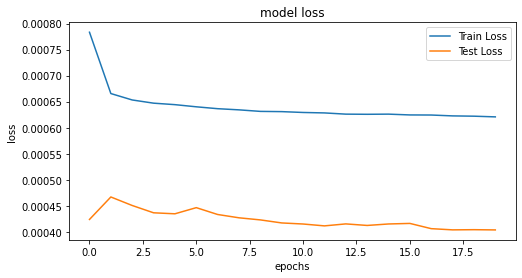

In [78]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

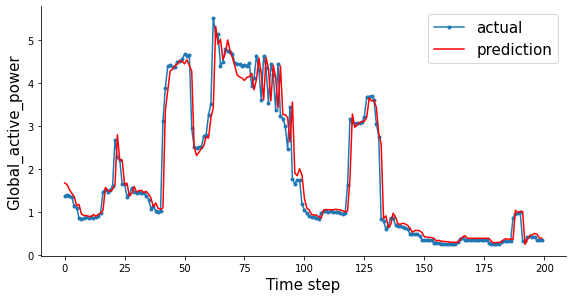

In [79]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();